In [ ]:
# import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import nltk
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split


df = pd.read_csv("../../../dataset/Restaurant reviews.csv")
df

df.drop(index=df[df['Rating'] == "Like"].index, inplace=True)

# 1 = Positive, 0 = Negative Review
df['Target'] = df['Rating'].apply(lambda x: 1 if x > 3.0 else 0)

df.drop(columns=['Rating'], inplace=True)


from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words("english"))
important_words = {"not", "no", "nor", "never"}
final_stopwords = stop_words - important_words

lemmatize = WordNetLemmatizer()

# Clean the text
corpus = []
for i in range(0, len(df)):
    reviews = re.sub('[^a-zA-Z]', ' ', df['Review'].iloc[i])
    reviews = reviews.lower()
    reviews = word_tokenize(reviews, language="english")
    reviews = [lemmatize.lemmatize(word) for word in reviews if word not in final_stopwords]
    reviews = " ".join(reviews).strip()
    corpus.append(reviews)

# define vocabulary size
voc_size = 10000
one_hot_repre = [one_hot(word, voc_size) for word in corpus]

# Create X and y
X = one_hot_repre
y = df['Target']

# Split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# apply pad sequence
max_length=500
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)


# Build RNN model
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=128, input_length=max_length))
model.add(SimpleRNN(128, activation="relu", return_sequences=True))
model.add(SimpleRNN(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

# Setup EarlyStopping
earlystoping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=[X_test, y_test],
    callbacks=[earlystoping]
)

# save model
model.save("simple_rnn.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

# load model
from tensorflow.keras.models import load_model
model = load_model('simple_rnn.h5')

# Function to preprocess user input
def preprocess_text(text):
    reviews = re.sub('[^a-zA-Z]', ' ', text)
    reviews = reviews.lower() 
    reviews = word_tokenize(reviews, language="english")
    reviews = [lemmatize.lemmatize(word) for word in reviews if word not in final_stopwords]
    preprocess_text = " ".join(reviews).strip()
    encoded_review = one_hot(preprocess_text, voc_size)
    padded_review = pad_sequences([encoded_review], maxlen=max_length)
    return padded_review

def predict_sentiment(review):
    processes_input = preprocess_text(review)
    prediction = model.predict(processes_input)
    sentiment = 'Positive' if prediction[0][0] > 0.6 else 'Negative'
    return sentiment, prediction[0][0]


example_review = "If you’re looking for great food and excellent service, this is the place. Every dish was beautifully presented and tasted incredible."
sentiment, score = predict_sentiment(example_review)

print("Review Text: ", example_review)
print("Sentiment: ", sentiment)
print("Score: ", score)




In [1]:
feedback_data = [
    {"text": "The food was amazing!", "sentiment": "Positive"},
    {"text": "The service was horrible!", "sentiment": "Negative"},
    {"text": "It was okay, not great but not bad.", "sentiment": "Neutral"},
    {"text": "Really loved the dessert!", "sentiment": "Positive"},
    {"text": "Waited too long.", "sentiment": "Negative"}
]

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

# Step 1: Count each sentiment
sentiments = [fb['sentiment'] for fb in feedback_data]
sentiment_count = Counter(sentiments)

In [4]:
sentiments

['Positive', 'Negative', 'Neutral', 'Positive', 'Negative']

In [5]:
sentiment_count

Counter({'Positive': 2, 'Negative': 2, 'Neutral': 1})

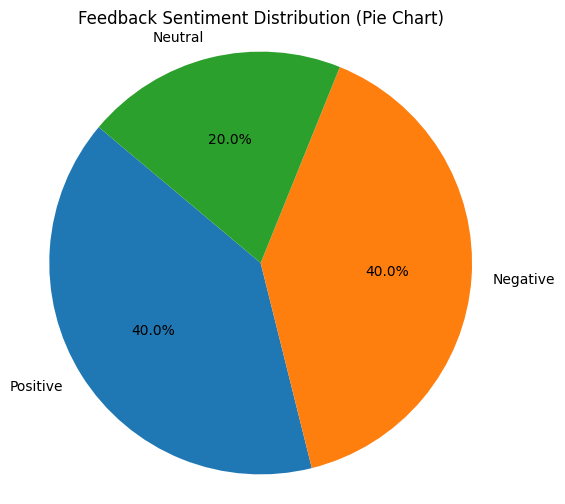

In [6]:
# Step 2: Plot Pie Chart
plt.figure(figsize=(6,6))
plt.pie(sentiment_count.values(), labels=sentiment_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Feedback Sentiment Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

In [8]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


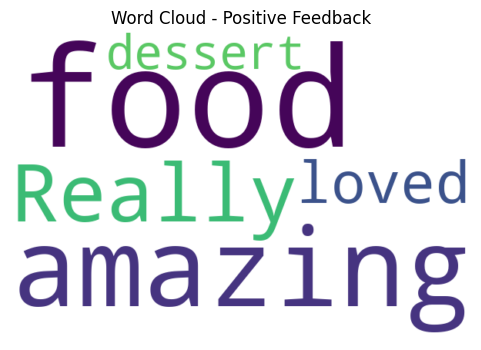

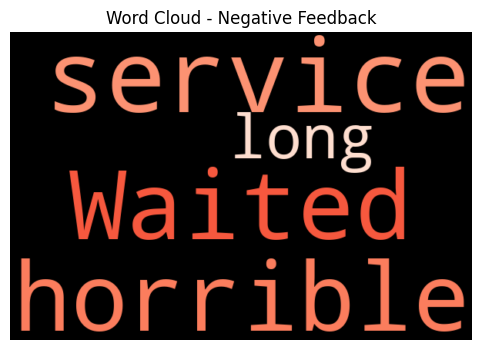

In [9]:
from wordcloud import WordCloud

# Filter texts
positive_text = " ".join([fb['text'] for fb in feedback_data if fb['sentiment'] == 'Positive'])
negative_text = " ".join([fb['text'] for fb in feedback_data if fb['sentiment'] == 'Negative'])

# Positive WordCloud
positive_wc = WordCloud(width=600, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(7, 4))
plt.imshow(positive_wc, interpolation='bilinear')
plt.title("Word Cloud - Positive Feedback")
plt.axis('off')
plt.show()

# Negative WordCloud
negative_wc = WordCloud(width=600, height=400, background_color='black', colormap='Reds').generate(negative_text)
plt.figure(figsize=(7, 4))
plt.imshow(negative_wc, interpolation='bilinear')
plt.title("Word Cloud - Negative Feedback")
plt.axis('off')
plt.show()